## **Model Prototyping**

This notebook builds and evaluates initial text classification models  
to detect spoiler vs non-spoiler reviews.

Baseline models tested:
- Multinomial Naive Bayes
- Logistic Regression


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import nltk
import re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score, f1_score
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
import os, torch
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import (BertTokenizerFast, BertForSequenceClassification,
                          DataCollatorWithPadding, get_linear_schedule_with_warmup)
from transformers import TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import joblib

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

/home/electronic/Downloads/2025H1400069G/plot-protector-as-on-17-11-2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/electronic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/electronic/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/electronic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df = pd.read_feather("../data/preprocessed_reviews.feather")

### Adding Features
- `has_spoiler_tag`
- `full_text`

In [ ]:
df["full_text"] = df["original_review_summary"] + " " + df["original_review_text"]
df["has_spoiler_tag"] = df["review_text"].apply(lambda x : "spoiler" in x)

### Splitting the data for training and testing

In [ ]:
X = df[["full_text", "has_spoiler_tag", "review_text_ner"]]
y = df["is_spoiler"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_text = X_train["full_text"]
X_test_text = X_test["full_text"]
y_test = y_test.astype(str)

In [ ]:
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("Spoiler ratio (train):", y_train.value_counts(normalize=True))

Training samples: 459130
Testing samples: 114783
Spoiler ratio (train): is_spoiler
False    0.737027
True     0.262973
Name: proportion, dtype: float64


In [ ]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return " ".join(lemmatizer.lemmatize(w) for w in text.split())

X_train_clean_text = [clean_text(t) for t in X_train_text]
X_test_clean_text = [clean_text(t) for t in X_test_text]

### Vectorizing the `full_text` column

In [ ]:
tfidf_full = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=3,
    max_df=0.8,
    sublinear_tf=True,
    stop_words='english'
)

X_train_tfidf = tfidf_full.fit_transform(X_train_clean_text)
X_test_tfidf = tfidf_full.transform(X_test_clean_text)

In [ ]:
keywords = [
    "plot twist", "ending", "spoiler", "die", "surprise", "reveal", "betrayal",
    "twist", "kill", "death", "betray",
    "secret", "hidden truth", "big reveal", "unexpected", "shocking", "truth come out",
    "turn out", "actually", "real identity", "mask off", "double life", "deception",
    "disguise", "undercover", "false", "pretend", "plot reveal", "confession",
    "murder", "die in the end", "sacrifice", "fatal", "tragic end",
    "last scene", "final moment", "shot", "poison", "accident", "suicide",
    "dead", "death scene", "funeral", "grave",
    "turn against", "double cross", "traitor", "backstab", "deceive", "lie",
    "set up", "frame", "sell out", "enemy", "betrayal arc",
    "finale", "ending explain", "last episode", "climax", "final battle",
    "resolution", "conclusion", "credit scene", "after credit", "final twist",
    "mind blowing", "psychological", "hallucination", "dream", "illusion", "impostor",
    "gaslight", "paradox", "memory loss", "not real", "imagine", "alternate reality",
    "simulation", "hidden motive", "true story", "cover up", "reveal all", "plot uncovered",
    "secret revealed", "truth revealed", "twist ending", "unexpected ending",
    "major twist", "final reveal", "plot expose", "truth exposed",
    "identity reveal", "mask reveal", "real face", "truth behind", "dark secret",
    "hidden agenda", "big secret", "truth uncovered", "plot leak", "spoiler alert",
    "plot summary", "hidden clue", "truth discovered", "unmask", "truth behind the scenes",
    "ending reveal", "real story", "real meaning", "twist plot", "deceptive plot",
    "it was all a dream", "everything was fake", "alternate timeline", "fake death",
    "he never existed", "she never existed", "was alive", "alive after all",
    "they faked it", "time travel", "loop", "flashback", "false memory",
    "misdirection", "unreliable narrator", "true villain", "unexpected killer",
    "it was him", "it was her", "plot uncovered", "truth revealed",
    "the big twist", "turn of events", "revealed later", "flashforward",
    "time skip", "he returns", "she returns", "back from dead"
]

In [ ]:
lemmatized_keywords = set([clean_text(k) for k in keywords])

In [ ]:
tfidf_kw = TfidfVectorizer(
    vocabulary=lemmatized_keywords,
    ngram_range=(1, 3),
    lowercase=True
)
X_train_kw = tfidf_kw.fit_transform(X_train_clean_text)
X_test_kw = tfidf_kw.transform(X_test_clean_text)

### Putting everything together

In [ ]:
X_train_numeric = X_train[["has_spoiler_tag"]].copy()
X_train_numeric["has_spoiler_tag"] = X_train_numeric["has_spoiler_tag"].astype(int)

X_test_numeric = X_test[["has_spoiler_tag"]].copy()
X_test_numeric["has_spoiler_tag"] = X_test_numeric["has_spoiler_tag"].astype(int)

In [ ]:
X_train_combined = hstack([
    X_train_tfidf,
    X_train_kw,
    csr_matrix(X_train_numeric.values)
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_kw,
    csr_matrix(X_test_numeric.values)
])

## **Training with Naive Bayes**

In [ ]:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1')
grid.fit(X_train_combined, y_train)
print(grid.best_params_)

{'alpha': 0.01}


In [ ]:
nb = MultinomialNB(alpha=grid.best_params_['alpha'])
nb.fit(X_train_combined, y_train)
nb_probs = nb.predict_proba(X_test_combined)[:, 1]

In [ ]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (nb_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test.map({'False':0,'True':1}), y_pred, average='binary', zero_division=np.nan)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")


Best Threshold: 0.25
Best F1-Score: 0.5293


              precision    recall  f1-score   support

       False       0.85      0.73      0.79     84598
        True       0.46      0.63      0.53     30185

    accuracy                           0.70    114783
   macro avg       0.65      0.68      0.66    114783
weighted avg       0.74      0.70      0.72    114783



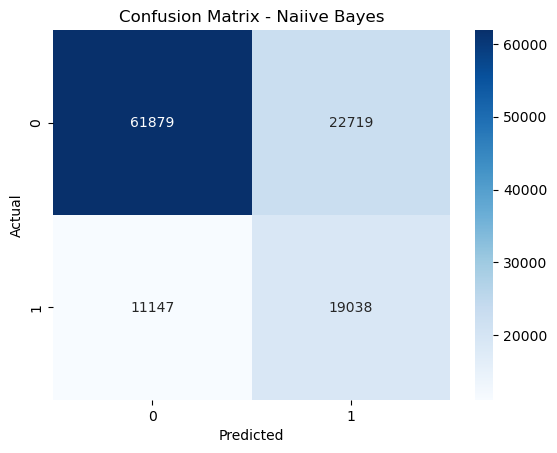

In [ ]:
y_pred = np.where(nb_probs > best_threshold, 'True', 'False')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naiive Bayes")
plt.show()

In [ ]:
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(
    y_test.map({'False': 0, 'True': 1}),
    (y_pred == 'True').astype(int),
    average='binary',
    zero_division=np.nan
)
accuracy_nb = accuracy_score(y_test, y_pred)
macro_f1_nb = f1_score(y_test, y_pred, average='macro')

## **Training with Logistic Regression**

In [ ]:
lr = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
    solver='saga',
    n_jobs=-1
)
lr.fit(X_train_combined, y_train)
lr_probs = lr.predict_proba(X_test_combined)[:, 1]

In [ ]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (lr_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test.map({'False':0,'True':1}), y_pred, average='binary', zero_division=np.nan)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")

Best Threshold: 0.51
Best F1-Score: 0.5599


              precision    recall  f1-score   support

       False       0.86      0.76      0.81     84598
        True       0.49      0.65      0.56     30185

    accuracy                           0.73    114783
   macro avg       0.68      0.71      0.68    114783
weighted avg       0.76      0.73      0.74    114783



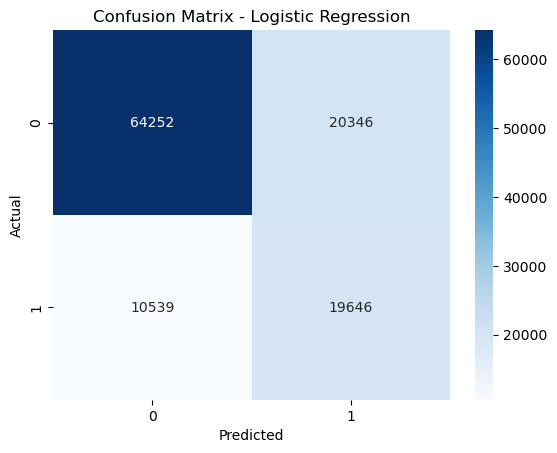

In [ ]:
y_pred = np.where(lr_probs > best_threshold, 'True', 'False')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [ ]:
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(
    y_test.map({'False': 0, 'True': 1}),
    (y_pred == 'True').astype(int),
    average='binary',
    zero_division=np.nan
)
accuracy_lr = accuracy_score(y_test, y_pred)
macro_f1_lr = f1_score(y_test, y_pred, average='macro')

### **Comparing both the results**

In [ ]:
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Precision (Spoiler)': [round(precision_nb, 2), round(precision_lr,2)],
    'Recall (Spoiler)': [round(recall_nb,2), round(recall_lr,2)],
    'F1 (Spoiler)': [round(f1_nb,2), round(f1_lr,2)],
    'Accuracy': [round(accuracy_nb,2), round(accuracy_lr,2)],
    'Macro F1': [round(macro_f1_nb,2), round(macro_f1_lr,2)]
})

results

,Model,Precision (Spoiler),Recall (Spoiler),F1 (Spoiler),Accuracy,Macro F1
0,Naive Bayes,0.46,0.63,0.53,0.70,0.66
1,Logistic Regression,0.49,0.65,0.56,0.73,0.68


## **BERT**

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

@dataclass
class BERTConfig:
    model_name: str = "bert-base-uncased"
    max_length: int = 256
    train_bs: int = 32
    eval_bs: int = 64
    lr: float = 2e-5
    weight_decay: float = 0.01
    epochs: int = 8
    warmup_ratio: float = 0.1
    gradient_accumulation_steps: int = 2
    fp16: bool = True
    num_workers: int = 0  # Set to 0 to avoid forking issues
    gradient_checkpointing: bool = True
    outdir: str = "../models/bert"
    max_grad_norm: float = 1.0

cfg = BERTConfig()
os.makedirs(cfg.outdir, exist_ok=True)

print("=" * 47)
print("BERT TRAINING CONFIGURATION")
print("=" * 47)
print(f"Model: {cfg.model_name}")
print(f"Max length: {cfg.max_length}")
print(f"Train batch size: {cfg.train_bs}")
print(f"Effective batch size: {cfg.train_bs * cfg.gradient_accumulation_steps}")
print(f"Eval batch size: {cfg.eval_bs}")
print(f"Learning rate: {cfg.lr}")
print(f"Weight decay: {cfg.weight_decay}")
print(f"Epochs: {cfg.epochs}")
print(f"Warmup ratio: {cfg.warmup_ratio}")
print(f"Mixed precision: {cfg.fp16}")
print(f"Gradient checkpointing: {cfg.gradient_checkpointing}")
print("=" * 47 + "\n")

BERT TRAINING CONFIGURATION
Model: bert-base-uncased
Max length: 256
Train batch size: 32
Effective batch size: 64
Eval batch size: 64
Learning rate: 2e-05
Weight decay: 0.01
Epochs: 8
Warmup ratio: 0.1
Mixed precision: True
Gradient checkpointing: True



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    torch.cuda.empty_cache()
else:
    print("TRAINING ON CPU! CHANGE AKSHIT CHANGE!!!!")

print("DATA HAS BEEN PLANTED! 40 seconds till-")

Using device: cuda
GPU: NVIDIA RTX 4500 Ada Generation
CUDA Version: 12.8
Available GPU memory: 25.39 GB
DATA HAS BEEN PLANTED! 40 seconds till-


In [11]:
train_df = pd.read_csv("../data/bert/train.csv")
val_df = pd.read_csv("../data/bert/val.csv")
test_df = pd.read_csv("../data/bert/test.csv")

print(f"Train size: {len(train_df):,}")
print(f"Val size: {len(val_df):,}")
print(f"Test size: {len(test_df):,}")

Train size: 459,130
Val size: 57,391
Test size: 57,392


In [13]:
le_path = "../data/bert/label_encoder.joblib"
if os.path.exists(le_path):
    le_spoiler = joblib.load(le_path)
    print("Label encoder loaded")
else:
    print("Creating label encoder...")
    all_labels = pd.concat([train_df["label"], val_df["label"], test_df["label"]])
    le_spoiler = LabelEncoder().fit(all_labels)
    joblib.dump(le_spoiler, le_path)
    print("Label encoder created and saved")

print(f"\nNumber of classes: {len(le_spoiler.classes_)}")
print(f"Classes: {le_spoiler.classes_}")
print(f"\nClass distribution in training set:")
print(train_df["label"].value_counts())
print(f"\nClass balance:")
print(train_df["label"].value_counts(normalize=True))

Label encoder loaded

Number of classes: 2
Classes: [False  True]

Class distribution in training set:
label
0    338391
1    120739
Name: count, dtype: int64

Class balance:
label
0    0.737027
1    0.262973
Name: proportion, dtype: float64


/home/electronic/Downloads/2025H1400069G/plot-protector-as-on-17-11-2025/.venv/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
class SpoilerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = [str(t) for t in texts]
        self.labels = labels.astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

print("The datasets are ready to be served!")


The datasets are ready to be served!


In [17]:
tokenizer = BertTokenizerFast.from_pretrained(cfg.model_name)
print(f"Tokenizer loaded: {cfg.model_name}")

Tokenizer loaded: bert-base-uncased


In [18]:
train_ds = SpoilerDataset(train_df["text"], train_df["label"], tokenizer, cfg.max_length)
val_ds = SpoilerDataset(val_df["text"], val_df["label"], tokenizer, cfg.max_length)
test_ds = SpoilerDataset(test_df["text"], test_df["label"], tokenizer, cfg.max_length)

print(f"Train dataset: {len(train_ds):,} samples")
print(f"Val dataset: {len(val_ds):,} samples")
print(f"Test dataset: {len(test_ds):,} samples")

Train dataset: 459,130 samples
Val dataset: 57,391 samples
Test dataset: 57,392 samples


In [19]:
train_loader = DataLoader(
    train_ds,
    batch_size=cfg.train_bs,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_ds,
    batch_size=cfg.eval_bs,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_ds,
    batch_size=cfg.eval_bs,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nTrain batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"Test batches: {len(test_loader):,}")


Train batches: 14,348
Val batches: 897
Test batches: 897


In [20]:
num_labels = len(le_spoiler.classes_)
model = BertForSequenceClassification.from_pretrained(
    cfg.model_name,
    num_labels=num_labels
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
if cfg.gradient_checkpointing:
    model.gradient_checkpointing_enable()
    print("Gradient checkpointing enabled")

Gradient checkpointing enabled


In [22]:
cls_counts = train_df["label"].value_counts().sort_index().values
cls_weights = torch.tensor(
    cls_counts.sum() / (num_labels * cls_counts),
    dtype=torch.float,
    device=device
)

print(f"Model loaded with {num_labels} classes")
print(f"Class weights: {cls_weights.cpu().numpy()}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=cfg.lr,
    weight_decay=cfg.weight_decay
)

# Scheduler
total_steps = (len(train_loader) // cfg.gradient_accumulation_steps) * cfg.epochs
num_warmup = int(cfg.warmup_ratio * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup,
    num_training_steps=total_steps
)

Model loaded with 2 classes
Class weights: [0.6784016 1.9013326]
Total parameters: 109,483,778
Trainable parameters: 109,483,778


In [23]:
criterion = torch.nn.CrossEntropyLoss(weight=cls_weights)

# Gradient scaler for mixed precision
scaler = torch.amp.GradScaler('cuda',enabled=cfg.fp16)

print(f"Optimizer: AdamW (lr={cfg.lr}, weight_decay={cfg.weight_decay})")
print(f"Scheduler: Linear with warmup")
print(f"  Total steps: {total_steps:,}")
print(f"  Warmup steps: {num_warmup:,}")
print(f"Loss: CrossEntropyLoss with class weights")
print(f"Mixed precision: {cfg.fp16}")

Optimizer: AdamW (lr=2e-05, weight_decay=0.01)
Scheduler: Linear with warmup
  Total steps: 57,392
  Warmup steps: 5,739
Loss: CrossEntropyLoss with class weights
Mixed precision: True


In [24]:
def train_epoch(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}")

    for step, batch in enumerate(pbar):
        batch = {k: v.to(device) for k, v in batch.items()}

        # Mixed precision forward pass
        with torch.amp.autocast('cuda', enabled=cfg.fp16):
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            loss = criterion(outputs.logits, batch["labels"])
            loss = loss / cfg.gradient_accumulation_steps

        # Backward pass
        scaler.scale(loss).backward()

        # Update metrics
        total_loss += loss.item() * cfg.gradient_accumulation_steps
        with torch.no_grad():
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)

        # Gradient accumulation step
        if (step + 1) % cfg.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item() * cfg.gradient_accumulation_steps:.4f}',
            'acc': f'{correct / total:.4f}',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}'
        })

    return total_loss / len(train_loader), correct / total

In [25]:
@torch.no_grad()
def evaluate(loader, desc="Eval"):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(loader, desc=desc)

    for batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.amp.autocast('cuda', enabled=cfg.fp16):
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )

        total_loss += outputs.loss.item() * batch["labels"].size(0)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(batch["labels"].cpu().tolist())

        pbar.set_postfix({'loss': f'{outputs.loss.item():.4f}'})

    avg_loss = total_loss / len(all_labels)
    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, accuracy, f1_macro, (all_labels, all_preds)

In [26]:
train_losses, val_losses = [], []
train_accs, val_accs, val_f1s = [], [], []
best_val_f1 = 0
start_time = time.time()

for epoch in range(1, cfg.epochs + 1):
    epoch_start = time.time()

    print(f"\n{'=' * 70}")
    print(f"Epoch {epoch}/{cfg.epochs}")
    print('=' * 70)

    # Train
    train_loss, train_acc = train_epoch(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc, val_f1, _ = evaluate(val_loader, desc="Validation")
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    epoch_time = time.time() - epoch_start

    # Print results
    print(f"\nEpoch {epoch} Results:")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    print(f"  Time: {epoch_time / 60:.2f} minutes")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_path = os.path.join(cfg.outdir, "best_model")
        os.makedirs(best_model_path, exist_ok=True)
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"  ✓ New best model saved! (F1: {best_val_f1:.4f})")

    # Save checkpoint every 2 epochs
    if epoch % 2 == 0:
        checkpoint_path = os.path.join(cfg.outdir, f"checkpoint_epoch_{epoch}")
        os.makedirs(checkpoint_path, exist_ok=True)
        model.save_pretrained(checkpoint_path)
        print(f"  ✓ Checkpoint saved at epoch {epoch}")

    # Clear cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

total_time = time.time() - start_time


print(f"Total time: {total_time / 3600:.2f} hours ({total_time / 60:.2f} minutes)")
print(f"Average time per epoch: {total_time / cfg.epochs / 60:.2f} minutes")
print(f"Best validation F1: {best_val_f1:.4f}")


Epoch 1/8


Validation: 100%|██████████| 897/897 [01:29<00:00, 10.02it/s, loss=0.3752]



Epoch 1 Results:
  Train - Loss: 0.5765, Acc: 0.6898
  Val   - Loss: 0.5141, Acc: 0.7447, F1: 0.6947
  Time: 40.89 minutes
  ✓ New best model saved! (F1: 0.6947)

Epoch 2/8


Validation: 100%|██████████| 897/897 [01:28<00:00, 10.08it/s, loss=0.3782]



Epoch 2 Results:
  Train - Loss: 0.5215, Acc: 0.7413
  Val   - Loss: 0.5034, Acc: 0.7510, F1: 0.7018
  Time: 40.60 minutes
  ✓ New best model saved! (F1: 0.7018)
  ✓ Checkpoint saved at epoch 2

Epoch 3/8


Validation: 100%|██████████| 897/897 [01:28<00:00, 10.09it/s, loss=0.3586]



Epoch 3 Results:
  Train - Loss: 0.4590, Acc: 0.7841
  Val   - Loss: 0.5178, Acc: 0.7488, F1: 0.7007
  Time: 40.89 minutes

Epoch 4/8


Validation: 100%|██████████| 897/897 [01:29<00:00, 10.01it/s, loss=0.3010]



Epoch 4 Results:
  Train - Loss: 0.3744, Acc: 0.8343
  Val   - Loss: 0.5510, Acc: 0.7538, F1: 0.6972
  Time: 40.86 minutes
  ✓ Checkpoint saved at epoch 4

Epoch 5/8


Validation: 100%|██████████| 897/897 [01:28<00:00, 10.09it/s, loss=0.3623]



Epoch 5 Results:
  Train - Loss: 0.2895, Acc: 0.8781
  Val   - Loss: 0.6489, Acc: 0.7416, F1: 0.6882
  Time: 40.72 minutes

Epoch 6/8


Validation: 100%|██████████| 897/897 [01:28<00:00, 10.09it/s, loss=0.3851]



Epoch 6 Results:
  Train - Loss: 0.2184, Acc: 0.9120
  Val   - Loss: 0.7567, Acc: 0.7756, F1: 0.6943
  Time: 40.62 minutes
  ✓ Checkpoint saved at epoch 6

Epoch 7/8


Validation: 100%|██████████| 897/897 [01:29<00:00, 10.02it/s, loss=0.4358]



Epoch 7 Results:
  Train - Loss: 0.1674, Acc: 0.9356
  Val   - Loss: 0.8718, Acc: 0.7693, F1: 0.6946
  Time: -291.93 minutes

Epoch 8/8


Validation: 100%|██████████| 897/897 [01:29<00:00, 10.02it/s, loss=0.4722]



Epoch 8 Results:
  Train - Loss: 0.1328, Acc: 0.9505
  Val   - Loss: 0.9669, Acc: 0.7656, F1: 0.6928
  Time: 40.83 minutes
  ✓ Checkpoint saved at epoch 8
Total time: -0.11 hours (-6.47 minutes)
Average time per epoch: -0.81 minutes
Best validation F1: 0.7018


In [27]:
best_model = BertForSequenceClassification.from_pretrained(
    os.path.join(cfg.outdir, "best_model")
).to(device)

model = best_model
test_loss, test_acc, test_f1, (test_labels, test_preds) = evaluate(
    test_loader, desc="Test"
)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  F1 (macro): {test_f1:.4f}")

print("\nClassification Report:")
print(classification_report(
    test_labels,
    test_preds,
    target_names=le_spoiler.classes_,
    digits=4
))

Test: 100%|██████████| 897/897 [01:29<00:00, 10.06it/s, loss=0.4683]



Test Results:
  Loss: 0.5049
  Accuracy: 0.7497
  F1 (macro): 0.7013

Classification Report:


TypeError: object of type 'numpy.bool' has no len()

In [ ]:
results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'val_f1s': val_f1s,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'test_f1': test_f1,
    'best_val_f1': best_val_f1
}

import json
with open(os.path.join(cfg.outdir, "training_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Training results saved to {cfg.outdir}/training_results.json")

# **De-BERTa-v3**

In [1]:
# Cell 1: Imports and load preprocessed CSVs

import os
import pandas as pd

from transformers import DebertaV2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

data_dir = "../data/de_berta_v3"

train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
val_df   = pd.read_csv(os.path.join(data_dir, "val.csv"))
test_df  = pd.read_csv(os.path.join(data_dir, "test.csv"))

print("Train shape:", train_df.shape)
print("Val shape:",   val_df.shape)
print("Test shape:",  test_df.shape)
print(train_df.head())


/home/electronic/Downloads/2025H1400069G/plot-protector-as-on-17-11-2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Train shape: (461323, 3)
Val shape: (56607, 3)
Test shape: (55983, 3)
    movie_id                                               text  label
0  tt0111161  In its Oscar year, Shawshank Redemption (writt...      1
1  tt0111161  The Shawshank Redemption is without a doubt on...      1
2  tt0111161  I believe that this film is the best story eve...      1
3  tt0111161  **Yes, there are SPOILERS here**This film has ...      1
4  tt0111161  At the heart of this extraordinary movie is a ...      1


In [2]:
# Cell 2: Tokenizer

MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LEN = 256

tokenizer = DebertaV2Tokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer vocab size:", tokenizer.vocab_size)


Tokenizer vocab size: 128000


In [3]:
# Cell 3: Dataset class (same as before)

class IMDBSpoilerDataset(Dataset):
    def __init__(self, df, tokenizer, max_len: int = 256):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids":      encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels":         torch.tensor(label, dtype=torch.long)
        }

train_dataset = IMDBSpoilerDataset(train_df, tokenizer, max_len=MAX_LEN)
val_dataset   = IMDBSpoilerDataset(val_df,   tokenizer, max_len=MAX_LEN)
test_dataset  = IMDBSpoilerDataset(test_df,  tokenizer, max_len=MAX_LEN)


In [4]:
# Cell 4: DataLoaders (what was previously optional Cell 10)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

batch = next(iter(train_loader))
for k, v in batch.items():
    print(k, v.shape, v.dtype)


input_ids torch.Size([16, 256]) torch.int64
attention_mask torch.Size([16, 256]) torch.int64
labels torch.Size([16]) torch.int64


In [5]:
# Cell 11: Model + training imports

import torch
import torch.nn as nn
from transformers import (
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [6]:
# Cell 12: Load DeBERTa-v3-base model for binary classification

NUM_LABELS = 2
MODEL_NAME = "microsoft/deberta-v3-base"  # same as tokenizer

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="single_label_classification"
)

model.to(DEVICE)
print("Model loaded on:", DEVICE)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda


In [7]:
# Cell 13: Class weights, optimizer, scheduler

from collections import Counter

# Compute class weights from train_df
label_counts = Counter(train_df["label"].tolist())
total = sum(label_counts.values())
class_weights = [
    total / (NUM_LABELS * label_counts.get(i, 1)) for i in range(NUM_LABELS)
]

print("Label counts:", label_counts)
print("Class weights:", class_weights)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

EPOCHS = 10
LR = 2e-5
WARMUP_RATIO = 0.1

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print("Total steps:", total_steps, "| Warmup steps:", warmup_steps)


Label counts: Counter({0: 341802, 1: 119521})
Class weights: [0.674839526977607, 1.929882614770626]
Total steps: 288330 | Warmup steps: 28833


In [8]:
# Cell 14: Training and evaluation functions

def train_one_epoch(model, data_loader, optimizer, scheduler, criterion, device):
    model.train()
    epoch_loss = 0.0

    all_preds = []
    all_labels = []

    pbar = tqdm(data_loader, desc="Train", leave=False)
    for batch in pbar:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item() * input_ids.size(0)

        preds = torch.argmax(logits, dim=-1).detach().cpu().numpy()
        labels_np = labels.detach().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels_np)

    avg_loss = epoch_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="binary")

    return avg_loss, acc, f1


def eval_model(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(data_loader, desc="Eval", leave=False)
        for batch in pbar:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            epoch_loss += loss.item() * input_ids.size(0)

            preds = torch.argmax(logits, dim=-1).detach().cpu().numpy()
            labels_np = labels.detach().cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels_np)

    avg_loss = epoch_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="binary")

    return avg_loss, acc, f1, all_labels, all_preds


In [9]:
# Cell 15: Main training loop

BEST_MODEL_PATH = "deberta_v3_best.pt"

best_val_f1 = 0.0

for epoch in range(1, EPOCHS + 1):
    print("=" * 70)
    print(f"Epoch {epoch}/{EPOCHS}")

    train_loss, train_acc, train_f1 = train_one_epoch(
        model,
        train_loader,
        optimizer,
        scheduler,
        criterion,
        DEVICE
    )

    val_loss, val_acc, val_f1, _, _ = eval_model(
        model,
        val_loader,
        criterion,
        DEVICE
    )

    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"✓ New best model saved with F1 = {best_val_f1:.4f}")

print("=" * 70)
print("Training completed.")
print(f"Best validation F1: {best_val_f1:.4f}")


Epoch 1/10


Train - Loss: 0.4762, Acc: 0.7777, F1: 0.4335
Val   - Loss: 0.4725, Acc: 0.7778, F1: 0.5481
✓ New best model saved with F1 = 0.5481
Epoch 2/10


Train - Loss: 0.4496, Acc: 0.7977, F1: 0.4973
Val   - Loss: 0.4562, Acc: 0.7945, F1: 0.5232
Epoch 3/10


Train - Loss: 0.4134, Acc: 0.8187, F1: 0.5770
Val   - Loss: 0.4757, Acc: 0.7920, F1: 0.5265
Epoch 4/10


Train - Loss: 0.3692, Acc: 0.8444, F1: 0.6572
Val   - Loss: 0.5137, Acc: 0.7898, F1: 0.4920
Epoch 5/10


Train - Loss: 0.3149, Acc: 0.8754, F1: 0.7359
Val   - Loss: 0.5505, Acc: 0.7853, F1: 0.5071
Epoch 6/10


Train - Loss: 0.2623, Acc: 0.9035, F1: 0.8017
Val   - Loss: 0.6812, Acc: 0.7752, F1: 0.5278
Epoch 7/10


Train - Loss: 0.2221, Acc: 0.9270, F1: 0.8521
Val   - Loss: 0.8873, Acc: 0.7742, F1: 0.5284
Epoch 8/10


Train - Loss: 0.1909, Acc: 0.9440, F1: 0.8882
Val   - Loss: 1.0512, Acc: 0.7729, F1: 0.5262
Epoch 9/10


KeyboardInterrupt: 

In [10]:
# Cell 16: Test evaluation with the best saved model

# Reload model weights from best checkpoint
best_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="single_label_classification"
)
best_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
best_model.to(DEVICE)

test_loss, test_acc, test_f1, test_labels, test_preds = eval_model(
    best_model,
    test_loader,
    criterion,
    DEVICE
)

print(f"Test - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, F1: {test_f1:.4f}")

print("\nClassification report:\n")
print(classification_report(test_labels, test_preds, digits=4))

print("Confusion matrix:")
print(confusion_matrix(test_labels, test_preds))


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test - Loss: 0.4946, Acc: 0.7673, F1: 0.5684

Classification report:

              precision    recall  f1-score   support

           0     0.8147    0.8684    0.8407     39586
           1     0.6222    0.5231    0.5684     16397

    accuracy                         0.7673     55983
   macro avg     0.7184    0.6958    0.7045     55983
weighted avg     0.7583    0.7673    0.7609     55983

Confusion matrix:
[[34377  5209]
 [ 7819  8578]]


# **Modified De-BERTa-v3**

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    get_linear_schedule_with_warmup, 
    DataCollatorWithPadding
)
from torch.optim import AdamW
from sklearn.metrics import classification_report, f1_score
from tqdm.auto import tqdm
import transformers

# 1. Suppress "overflowing tokens" warnings to keep output clean
transformers.logging.set_verbosity_error()

# 2. Configuration
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LEN = 256          # Reduced from 512 to 256 for 2x-3x speedup
BATCH_SIZE = 16        # Higher batch size since sequences are shorter
LR = 8e-6              # Low LR is critical for DeBERTaV3 stability
EPOCHS = 4
WEIGHT_DECAY = 0.01
DATA_DIR = "../data/de_berta_v3_context" # Ensure this matches your Preprocessing save path

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

/home/electronic/Downloads/2025H1400069G/plot-protector-as-on-17-11-2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
class IMDBSpoilerPairDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.text_a = df['text_a'].astype(str).tolist() # The Review
        self.text_b = df['text_b'].astype(str).tolist() # The Context (Plot/Genre)
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text_a)

    def __getitem__(self, idx):
        # DYNAMIC PADDING STRATEGY:
        # 1. We separate text_a and text_b.
        # 2. We TRUNCATE here to ensure no sample exceeds max_len.
        # 3. We do NOT PAD here (padding=False). The DataCollator will pad 
        #    the whole batch to the length of the longest sample in that batch.
        
        encoding = self.tokenizer(
            self.text_a[idx],
            self.text_b[idx],
            truncation=True,        # Strict truncation to max_len
            max_length=self.max_len,
            padding=False,          # Important: No padding yet!
            return_tensors=None     # Return standard python lists
        )

        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'labels': self.labels[idx]
        }

In [3]:
# 1. Load Data
print("Loading data...")
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
val_df = pd.read_csv(os.path.join(DATA_DIR, "val.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

# 2. Initialize Tokenizer
# use_fast=False is often required for DeBERTaV3 to handle special tokens correctly
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

# 3. Initialize Data Collator (The Speed Booster)
# This pads every batch dynamically during training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 4. Create Datasets
train_dataset = IMDBSpoilerPairDataset(train_df, tokenizer, MAX_LEN)
val_dataset = IMDBSpoilerPairDataset(val_df, tokenizer, MAX_LEN)
test_dataset = IMDBSpoilerPairDataset(test_df, tokenizer, MAX_LEN)

# 5. Create DataLoaders
# We pass collate_fn=data_collator to handle the padding
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=data_collator, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=data_collator, num_workers=2, pin_memory=True)

print(f"Data loaded. Train samples: {len(train_df)}")

Loading data...
Data loaded. Train samples: 461323


In [4]:
# 1. Load Model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(DEVICE)

# 2. Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.1 * total_steps), 
    num_training_steps=total_steps
)

# 3. Class Weights (Crucial for Imbalanced Data)
# Spoilers are class 1 (minority). We weight them higher.
# Approx ratio is 1:3 based on your data.
class_weights = torch.tensor([1.0, 3.0]).to(DEVICE) 
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# 4. Mixed Precision Scaler (Faster training on GPU)
scaler = torch.amp.GradScaler('cuda')

print("Model, Optimizer, and Loss Function initialized.")

Model, Optimizer, and Loss Function initialized.


In [5]:
def train_epoch(model, loader, optimizer, scheduler, loss_fn, scaler):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(loader, desc="Training")
    
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        optimizer.zero_grad()
        
        # Mixed Precision Context
        with torch.amp.autocast('cuda'):
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
        
        # Scaler Step
        scaler.scale(loss).backward()
        
        # Gradient Clipping (Stabilizes DeBERTa)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        
        # Store predictions for metrics
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_loss = total_loss / len(loader)
    f1 = f1_score(all_labels, all_preds)
    return avg_loss, f1

def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            with torch.amp.autocast('cuda'):
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = loss_fn(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    return avg_loss, all_labels, all_preds

In [6]:
best_f1 = 0
model_save_path = "best_deberta_context_model.pt"

print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    print(f"\n{'='*20} Epoch {epoch + 1}/{EPOCHS} {'='*20}")
    
    # Train
    train_loss, train_f1 = train_epoch(model, train_loader, optimizer, scheduler, loss_fn, scaler)
    
    # Validate
    val_loss, val_labels, val_preds = evaluate(model, val_loader, loss_fn)
    
    # Metrics
    val_report = classification_report(val_labels, val_preds, output_dict=True)
    val_f1 = val_report['1']['f1-score'] # Focus on Spoiler F1
    
    print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val F1:   {val_f1:.4f}")
    
    # Save Best
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), model_save_path)
        print(f"--> New Best Model Saved! (F1: {best_f1:.4f})")

print("\nTraining Complete.")

Starting training for 4 epochs...

==================== Epoch 1/4 ====================


Evaluating: 100%|██████████| 3538/3538 [02:12<00:00, 26.70it/s]


Train Loss: 0.5991 | Train F1: 0.5020
Val Loss:   0.5838 | Val F1:   0.5342
--> New Best Model Saved! (F1: 0.5342)

==================== Epoch 2/4 ====================


Evaluating: 100%|██████████| 3538/3538 [02:12<00:00, 26.66it/s]


Train Loss: 0.5500 | Train F1: 0.5558
Val Loss:   0.5761 | Val F1:   0.5452
--> New Best Model Saved! (F1: 0.5452)

==================== Epoch 3/4 ====================


Evaluating: 100%|██████████| 3538/3538 [02:12<00:00, 26.70it/s]


Train Loss: 0.5134 | Train F1: 0.5936
Val Loss:   0.5630 | Val F1:   0.5431

==================== Epoch 4/4 ====================


Evaluating: 100%|██████████| 3538/3538 [02:12<00:00, 26.70it/s]


Train Loss: 0.4776 | Train F1: 0.6313
Val Loss:   0.5798 | Val F1:   0.5417

Training Complete.


In [7]:
# Load best model weights
print("Loading best model for testing...")
model.load_state_dict(torch.load(model_save_path))

# Run Inference
test_loss, test_labels, test_preds = evaluate(model, test_loader, loss_fn)

print("\n" + "="*30)
print("FINAL TEST RESULTS")
print("="*30)
print(classification_report(test_labels, test_preds, target_names=['Non-Spoiler', 'Spoiler']))

Loading best model for testing...


Evaluating: 100%|██████████| 3499/3499 [02:11<00:00, 26.71it/s]



FINAL TEST RESULTS
              precision    recall  f1-score   support

 Non-Spoiler       0.85      0.67      0.75     39586
     Spoiler       0.47      0.71      0.57     16397

    accuracy                           0.68     55983
   macro avg       0.66      0.69      0.66     55983
weighted avg       0.74      0.68      0.69     55983

